In [60]:
from metro_utils import graph, extract_stations, pairs2rails, subsets, total_distance, gen_distance_matrix, graph_x
from station import Station
from city import City
from collections import defaultdict as dd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import gurobipy as gp
from gurobipy import GRB
from tqdm import tqdm

if 1:
    # Load test cases
    # Highly recommend https://www.mathsisfun.com/data/cartesian-coordinates-interactive.html for creating these easily

    from json import load

    ignore_fields = ["description", "comment", "source"]
    def filter_ignore(d):
        return {k: v for k, v in d.items() if k not in ignore_fields}

    with open("test_cases.json", "r") as f:
        tests = load(f, object_hook=filter_ignore)

    # Choose problem to use in code below
    test_choice = "hexagon"
    locations = tests[test_choice]["locations"]
    N_STATIONS = len(locations)
    kinds = tests[test_choice]["kinds"]

    city = City(**tests[test_choice])
    stations = city.stations

In [61]:
from numpy.random import shuffle, randint, choice
from copy import deepcopy

def initialise(N, K):
    x = np.zeros((N, N, K))
    
    order = list(range(N))
    
    for k in range(K):
        shuffle(order)
        for i in range(N-1):
            a = order[i]
            b = order[i+1]
            x[a, b, k] = x[b, a, k] = 1
            
    return x      

isolated_station = lambda x: not all(x.sum(axis=2).sum(axis=0))
rail_covers_every_station = lambda grid: not any(grid.sum(axis=0) == 0)
has_loop = lambda grid: not any(grid.sum(axis=0) == 1) and grid.sum() > 2
just_two_stations = lambda grid: (grid.sum() == 2)
get_stations_not_on_line = lambda grid: (grid.sum(axis=0) == 0).nonzero()[0]
get_middle_stations = lambda grid: (grid.sum(axis=0) == 2).nonzero()[0]
get_end_stations    = lambda grid: (grid.sum(axis=0) == 1).nonzero()[0]
get_line_stations   = lambda grid: (grid.sum(axis=0) != 0).nonzero()[0]
has_subtours = lambda grid: len(get_end_stations(grid)) > 2
empty = lambda grid: grid.sum() == 0

def get_neighbour(x, case=0):
    x = deepcopy(x)
    # How many lines to modify
    m = 1 + randint(x.shape[2])
    
    lines = list(range(x.shape[2]))
    shuffle(lines)
    
    lines_to_modify = lines[:m]
    
    for k in lines_to_modify:
        grid = x[:, :, k]
    
        pre_grid = deepcopy(grid)
    
        case = choice([1, 2, 3, 4]) if case == 0 else case
        
        if case == 1:
            # Case 1. Expand Rail line end (Includes forming loop)
            if not has_loop(grid):
                old_choices = list(get_end_stations(grid))
                new_choices = list(get_stations_not_on_line(grid)) + old_choices
                
                old = choice(old_choices)
                new = choice(new_choices)
                
                if new != old:
                    grid[old, new] = grid[new, old] = 1

        elif case == 2:
            # Case 2. Shrink Rail line end (Includes breaking loop)
            # This can make city invalid (considering station kinds)
            # But cost function makes the cost really high
            if has_loop(grid):
                # Pick edge to break
                choices = np.array(grid.nonzero()).T
                i, j = choices[choice(range(len(choices)))]
                grid[i, j] = grid[j, i] = 0
            else:
                # Pick end to shrink
                ends = get_end_stations(grid)
                old_end = choice(ends)
                new_end = grid[old_end, :].argmax()
                grid[old_end, new_end] = grid[new_end, old_end] = 0

                if isolated_station(x) or empty(grid):
                    grid[old_end, new_end] = grid[new_end, old_end] = 1

        elif case == 3:
            # Case 3. Add station in middle
            if not rail_covers_every_station(grid):
                choices = get_stations_not_on_line(grid)
                b = choice(choices)
                
                try:
                    a = choice(get_line_stations(grid))
                except:
                    print(grid)
                c = choice(grid[a].nonzero()[0])
                
                grid[a, b] = grid[b, a] = grid[b, c] = grid[c, b] = 1
                grid[a, c] = grid[c, a] = 0

        elif case == 4:
            # Case 4. Remove station in middle
            # If not just 2 stations
            if not just_two_stations(grid):
                choices = get_middle_stations(grid)
                b = choice(choices)
                a, c = grid[b, :].nonzero()[0]
                grid[a, b] = grid[b, a] = grid[b, c] = grid[c, b] = 0
                prev_ac = grid[a, c]
                grid[a, c] = grid[c, a] = 1

                if isolated_station(x):
                    grid[a, b] = grid[b, a] = grid[b, c] = grid[c, b] = 1
                    grid[a, c] = grid[c, a] = prev_ac
        
    return x


import networkx as nx
from networkx import from_numpy_matrix

M = 1e5

def edge_sum(stations, x):
    connections = x.sum(axis=2)
    dist = gen_distance_matrix(city)
    # weighted_adjacency is edge weight where edge exists, else 0
    weighted_adjacency = connections * dist
    G = from_numpy_matrix(weighted_adjacency)
    return G.size('weight')

def cost(stations, x):
    connections = 1 * (x.sum(axis=2) > 0)
    dist = gen_distance_matrix(city)
    # weighted_adjacency is edge weight where edge exists, else 0
    weighted_adjacency = connections * dist
    G = from_numpy_matrix(weighted_adjacency)
    
    all_paths = list(nx.all_pairs_shortest_path(G))
    
    station_dists = []
    all_kinds = {s.kind for s in stations}

    # For each starting station
    for i, paths in all_paths:
        start = stations[i]

        distances = {kind: M for kind in all_kinds if kind != start.kind}

        # Get its kind
        for j, path in paths.items():
            end = stations[j]
            # For each other station: If kind is different
            if start.kind != end.kind:
                rails = [stations[i] for i in path]
                # Work out distance to that station and retain if min
                distances[end.kind] = min(distances[end.kind], total_distance(rails))

        station_dists.append(sum(distances.values()))
        
    # Sum of min distances + sum of graph edge weight
    return sum(station_dists) + edge_sum(stations, x) / M

def simulated_annealing(stations, K, max_iter=100, cutoff_val=0.001):
    ''' Performs simulated annealing to find (try and find) the optimal configuration 
        K is number of lines '''
    # Initialise Configuration
    cur_x = initialise(len(stations), K)
    cur_cost = cost(stations, cur_x)
    best_x, best_cost = cur_x, cur_cost
    
    # Time
    t = 0
    
    while True:
        # Update current temperature
        T = np.exp(np.log(cutoff_val)*t / max_iter)
        if T < cutoff_val:
            # Return configuration and its value
            return best_x, best_cost
        
        # Make random change
        new_x = get_neighbour(cur_x)
        new_cost = cost(stations, new_x)
        
        # Keep change if it is an improvement (or randomly sometimes)
        if new_cost < cur_cost or np.random.uniform(0, 1) < T:
            cur_x, cur_cost = new_x, new_cost
            
            if cur_cost < best_cost:
                best_x, best_cost = cur_x, cur_cost
            
        t += 1

In [62]:
#city = City(n_stations=4, locations=[(0, 0), (1,0), (0, 10), (1, 10)], kinds=['square', 'circle']*2)

# 1 instance of unusual kinds
# Probability of kinds 

In [65]:
best_x, best_cost = None, M
for restart in tqdm(range(10)):
    res_x, res_cost = simulated_annealing(city.stations, K=2)
    if res_cost < best_cost:
        best_x, best_cost = res_x, res_cost
        print(best_cost)

 20%|████████████████▌                                                                  | 2/10 [00:00<00:00, 10.42it/s]

18.691501383967612
16.442402505236515


 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:00<00:00, 10.45it/s]

16.442323635390537


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.42it/s]


16.442323635390537 8.29482712474619


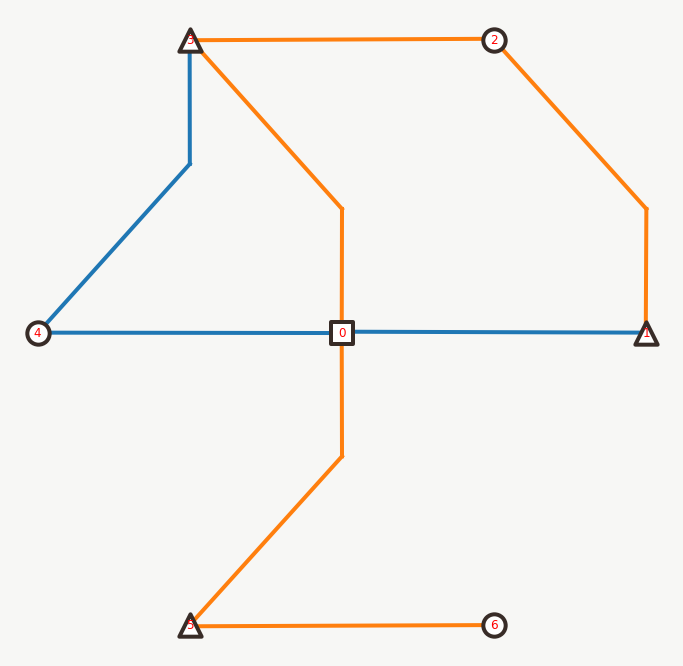

In [66]:
print(cost(city.stations, best_x), edge_sum(city.stations, best_x))

graph_x(city.stations, best_x)

8.703976864169878 29.36799384704472


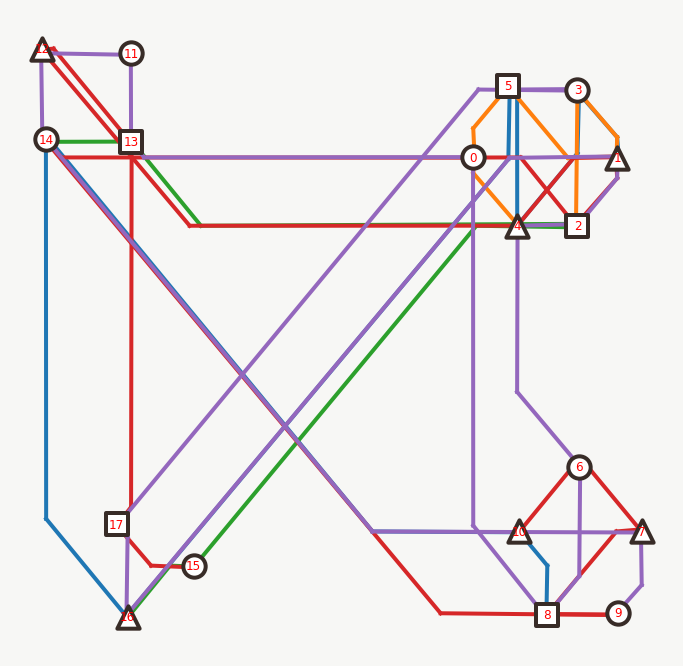

In [38]:
print(cost(city.stations, best_x), edge_sum(city.stations, best_x))

graph_x(city.stations, best_x)

26.8628163087092 7.918758144681265


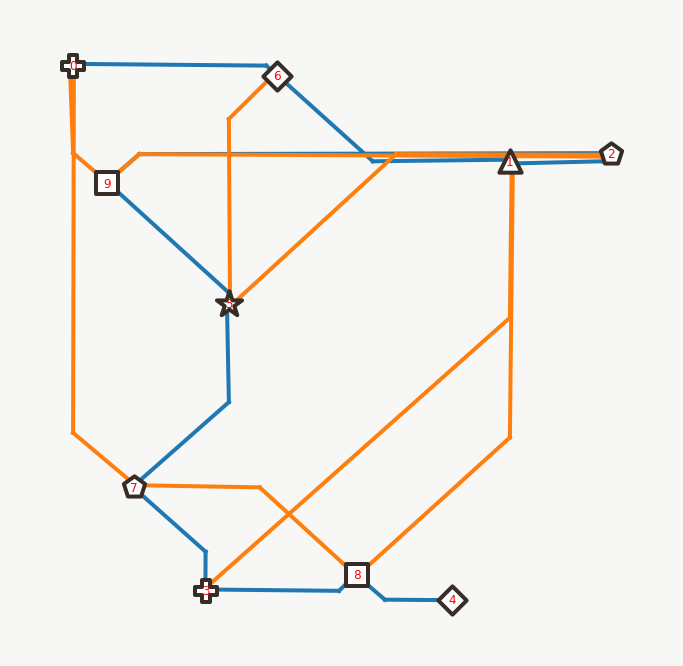

In [17]:
print(cost(city.stations, best_x), edge_sum(city.stations, best_x))

graph_x(city.stations, best_x)

In [136]:
x1 = np.array([
[[0, 0, 0, 0, 1, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1],
 [1, 0, 0, 0, 0, 1],
 [0, 0, 0, 1, 1, 0]],
[[0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 1, 0],
 [0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 1],
 [0, 0, 1, 0, 1, 0]]
]).transpose(2, 1, 0)

x2 = np.array([
[[0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 1, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 1],
 [1, 0, 0, 0, 1, 0]],
[[0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 1, 1, 0, 0]]
]).transpose(2, 1, 0)

34.2843944474619 0.00013313708498984762


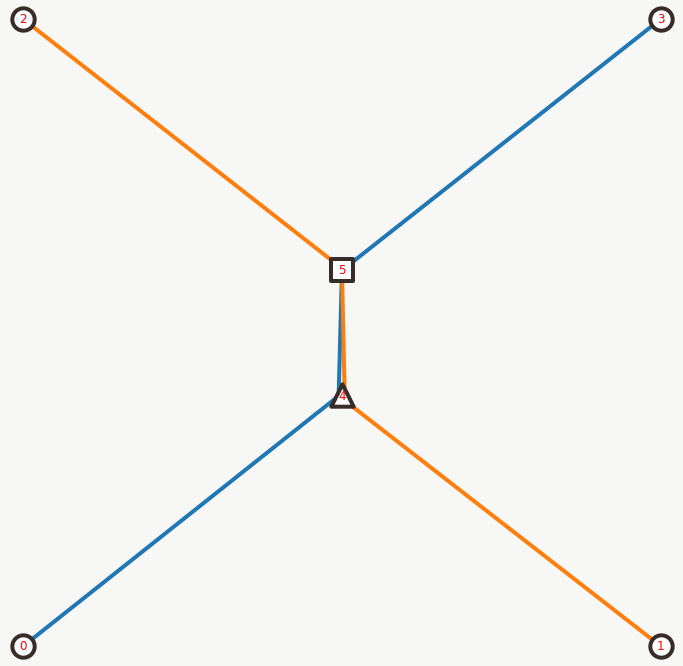

In [138]:
print(cost(city.stations, x1), edge_sum(city.stations, x1))

graph_x(city.stations, x1)

36.2844044474619


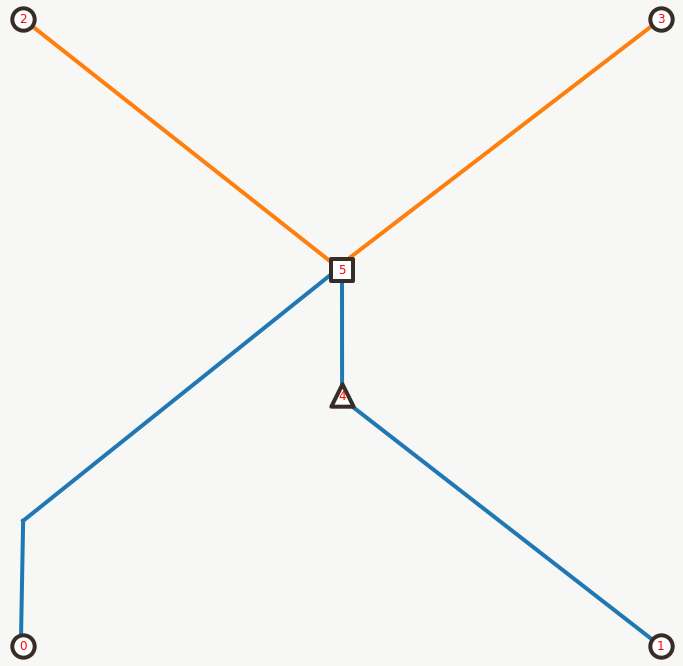

In [82]:
print(cost(city.stations, x2))

graph_x(city.stations, x2)

42.2843312474619


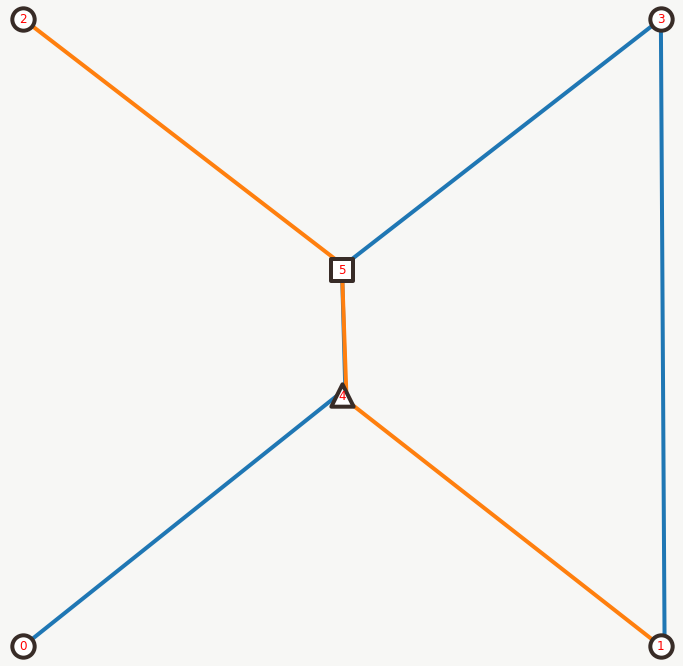

In [10]:
nn = get_neighbour(x1)

print(cost(city.stations, nn))

graph_x(city.stations, nn)

# Include Transition Costs

In [ ]:
def cost2(stations, x):
    connections = 1 * (x.sum(axis=2) > 0)
    dist = gen_distance_matrix(city)
    # weighted_adjacency is edge weight where edge exists, else 0
    weighted_adjacency = connections * dist
    G = from_numpy_matrix(weighted_adjacency)
    
    all_paths = list(nx.all_pairs_shortest_path(G))
    
    station_dists = []
    all_kinds = {s.kind for s in stations}

    # For each starting station
    for i, paths in all_paths:
        start = stations[i]

        distances = {kind: M for kind in all_kinds if kind != start.kind}

        # Get its kind
        for j, path in paths.items():
            end = stations[j]
            # For each other station: If kind is different
            if start.kind != end.kind:
                rails = [stations[i] for i in path]
                # Work out distance to that station and retain if min
                distances[end.kind] = min(distances[end.kind], total_distance(rails))

        station_dists.append(sum(distances.values()))
        
    # Sum of min distances + sum of graph edge weight
    return sum(station_dists) + edge_sum(stations, x) / M